# Chapter6. Statistical Machine Learning

In [1]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

# K-Nearest Neighbors

1. calculate distances between new point and existing points
2. find nearest k number of points
3. Label new point based on majority within k numer of points

Large K: Underfitting
Small K: Overfitting

A small Example:Predicting Loan Default

In [2]:
loan200=pd.read_csv('loan200.csv')
loan200.head(5)

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81


In [3]:
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


C:\Users\P6049834\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


↑0, 1  label assigned accoring to alphabetical order in this case default=0, paid off=1

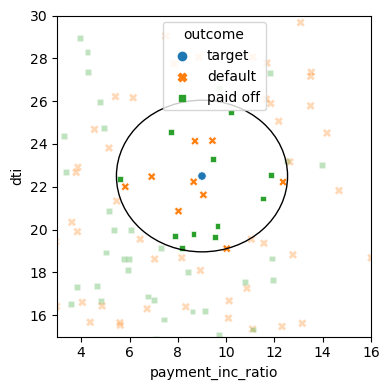

In [4]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

# Standardization(Normalization, Z-Scores)

In [12]:
loan_data = pd.read_csv('loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)


predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


kneighbors로 타겟에 가장 가까운 행 5개 식별가능, 그러나 표준화가 되어있지 않으므로 숫자가 큰 rebolbal기준으로만 가까운 행이 선택됨

In [17]:
newloan=loan_data.loc[0:0, predictors]
X=loan_data.loc[1:, predictors]
y=loan_data.loc[1:,outcome]

scaler=preprocessing.StandardScaler()
scaler.fit(X*1.0)


X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


스케일링 후 모든 변수에서 근접해짐, 모델 평가는 crossvalidation으로 실시

# KNN as a Feature Engine

KNN regression, 예를 들어 가장 가까운 값들의 평균으로 판매가격 예측 가능*페이지283

count    45342.000000
mean         0.501091
std          0.128728
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


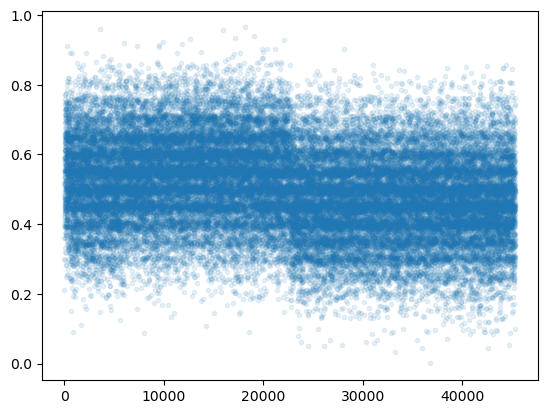

In [19]:
loan_data = pd.read_csv('loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

In [20]:
loan_data['borrower_score']

0        0.35
1        0.20
2        0.40
3        0.50
4        0.45
         ... 
45337    0.65
45338    0.50
45339    0.45
45340    0.35
45341    0.50
Name: borrower_score, Length: 45342, dtype: float64

# Tree Models

A Simple Example

The package scikit-learn has the class DecisionTreeClassifier to build a decision tree model. The function plotDecisionTree from the dmba package can be used to visualize the tree.



In [50]:
loan3000 = pd.read_csv('loan3000.csv')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


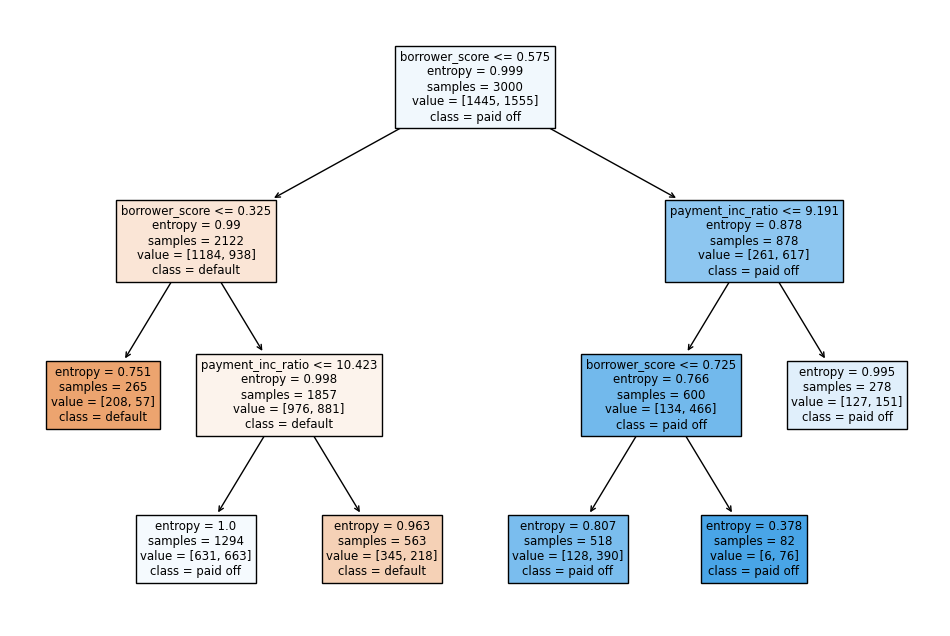

In [51]:
from sklearn import tree
plt.figure(figsize=(12, 8))
tree.plot_tree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_, filled=True)
plt.show()

split until impurity hits certain level. but deeper the tree, more the overfitting

1.random_state: 모델의 재현성을 위한 난수 발생기의 시드 값입니다. 동일한 값을 사용하면 모델이 동일한 결과를 재현할 수 있습니다.

2.criterion: 분할 기준을 지정하는 매개변수로, 'entropy' 또는 'gini' 중 하나를 선택할 수 있습니다. 'entropy'는 정보이득을 최대화하는 분할을 선택하고, 'gini'는 지니 불순도를 최소화하는 분할을 선택합니다.

3.min_impurity_decrease: 불순도 감소의 최소 임계값입니다. 이 값보다 불순도 감소가 작은 경우에는 분할을 수행하지 않습니다. 작은 값으로 설정할수록 분할이 더 세밀해지고 과적합을 줄일 수 있습니다.

In [52]:
pred=loan_tree.predict(loan3000[predictors])
pd.DataFrame(pred)

,0
0,paid off
1,paid off
2,paid off
3,paid off
4,default
...,...
2995,default
2996,paid off
2997,default
2998,paid off


In [53]:
unmatched_predictions = (pred != y).sum()
unmatched_predictions

1167

예측의 불일치를 줄이는 방법은 다양합니다. 여기에 몇 가지 일반적인 전략을 제시합니다:

더 많은 훈련 데이터 수집: 예측 성능을 향상시키기 위해 모델을 더 많은 다양한 데이터로 훈련할 수 있습니다. 이를 통해 모델은 더 많은 패턴과 변동성을 학습하게 되어 예측 결과의 불일치를 줄일 수 있습니다.

모델 파라미터 조정: DecisionTreeClassifier의 생성자에서 사용된 파라미터를 조정하여 모델의 복잡도를 변경할 수 있습니다. 예를 들어, max_depth, min_samples_split, min_samples_leaf 등의 파라미터를 조정하여 모델의 과적합을 줄이고 예측 성능을 향상시킬 수 있습니다.

특성 엔지니어링: 기존의 특성을 변형하거나 새로운 특성을 만들어 모델에 제공할 수 있습니다. 도메인 지식을 활용하여 특성을 선택, 변환 또는 조합할 수 있습니다. 이를 통해 모델이 더욱 의미 있는 특징을 학습하고 예측의 불일치를 줄일 수 있습니다.

앙상블 기법 사용: 여러 개의 모델을 조합하여 예측 결과를 결합하는 앙상블 기법을 사용할 수 있습니다. 예를 들어, 랜덤 포레스트(Random Forest)나 그래디언트 부스팅(Gradient Boosting) 등의 앙상블 모델을 사용하여 예측 성능을 향상시킬 수 있습니다.

이러한 전략들은 예측의 불일치를 줄이는 데 도움이 될 수 있지만, 주어진 데이터와 문제에 따라 효과가 다를 수 있습니다. 따라서 다양한 전략을 시도하며 모델의 성능을 개선하는데 중점을 두어야 합니다.

 min_samples_split을 쓰는 방법들은 임의적이어서 새로운 데이터에 대한 예측 정확도를 결정하기가 매우 어려움 교차검증이 필요함

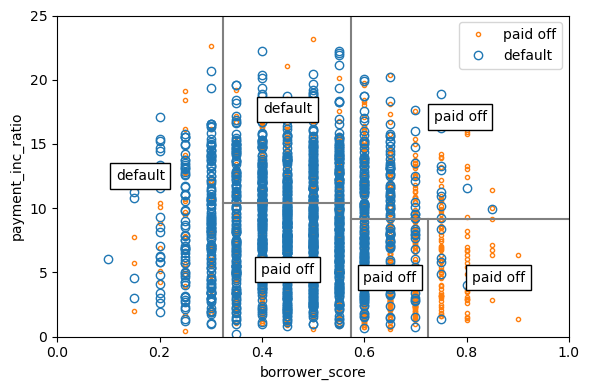

In [54]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

# Measuring Homogeneity or Impurity

In [55]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

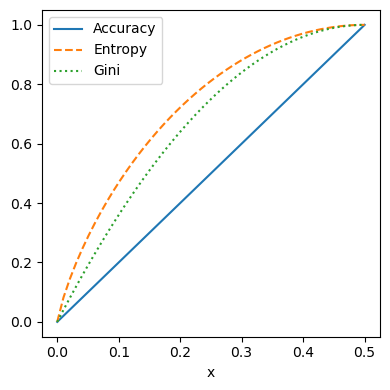

In [56]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

# Bagging and the Random Forest

Random Forest

트리 앙상블: 같은데이터에 대해 다양한 모델*트리 의 결과의 평균혹은 다수로 결정

배깅 랜덤포래스트: 데이터를 부트스트랩 한 뒤 다양한모델*트리 의 결과의 평균혹은 다수로 결정

In [59]:
predictors=['borrower_score','payment_inc_ratio']
outcome='outcome'

X=loan3000[predictors]
y=loan3000[outcome]

rf=RandomForestClassifier(n_estimators=500,random_state=1,
                         oob_score=True)
rf.fit(X,y)
print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


In [60]:
rf.predict(X)

array(['paid off', 'default', 'paid off', ..., 'default', 'default',
       'default'], dtype=object)

In [61]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

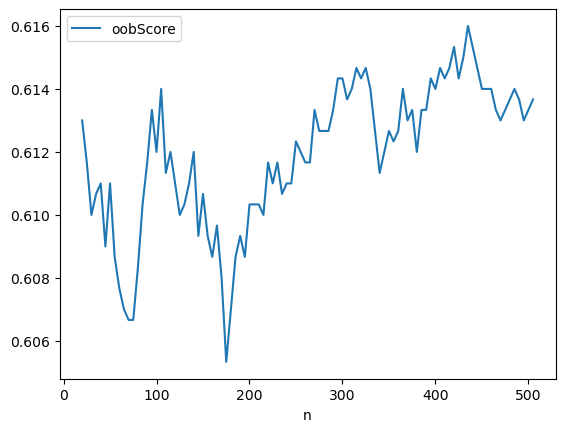

In [62]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')
plt.show()

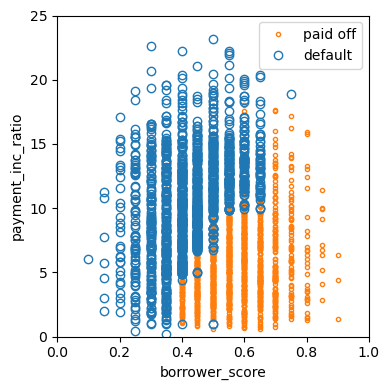

In [63]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

# Variable Importance

In [64]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X= pd.get_dummies(loan_data[predictors],drop_first=True)
y=loan_data[outcome]

rf_all=RandomForestClassifier(n_estimators=500,random_state=1)
rf_all.fit(X,y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [65]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                          test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

Features sorted by their score:
[(0.0724, 'borrower_score'), (0.0355, 'grade'), (0.0311, 'term_60 months'), (0.0122, 'annual_inc'), (0.0049, 'dti'), (0.0048, 'payment_inc_ratio'), (0.0034, 'open_acc'), (0.0026, 'purpose_small_business'), (0.0024, 'purpose__small_business'), (0.0017, 'purpose_credit_card'), (0.0016, 'revol_util'), (0.0007, 'loan_amnt'), (0.0007, 'home__OWN'), (0.0006, 'purpose__major_purchase'), (0.0004, 'purpose__other'), (0.0003, 'purpose_vacation'), (0.0003, 'purpose_moving'), (0.0001, 'purpose_wedding'), (0.0001, 'purpose__medical'), (0.0001, 'emp_len__ > 1 Year'), (0.0, 'purpose_medical'), (-0.0, 'purpose_major_purchase'), (0.0, 'pub_rec_zero'), (-0.0001, 'purpose_house'), (-0.0001, 'home__RENT'), (-0.0003, 'purpose_other'), (-0.0003, 'purpose__home_improvement'), (-0.0005, 'revol_bal'), (-0.0005, 'purpose_home_improvement'), (-0.0005, 'emp_length'), (-0.0009, 'delinq_2yrs_zero'), (-0.001, 'purpose__debt_consolidation'), (-0.0017, 'purpose_debt_consolidation')]


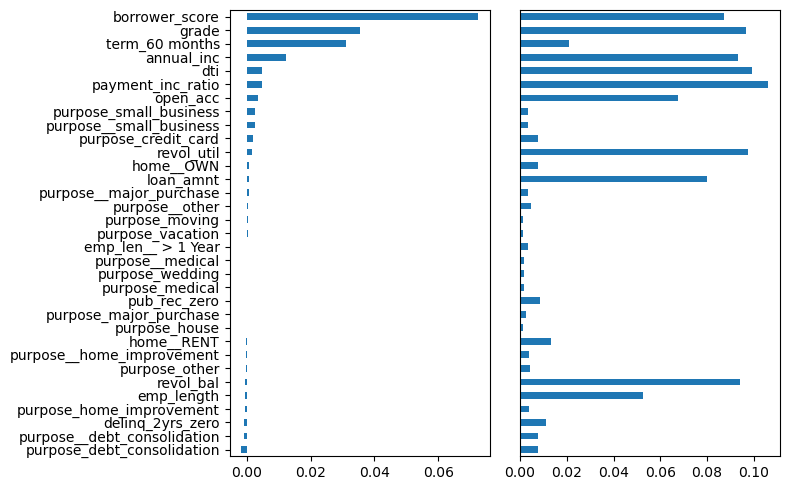

In [67]:
importances = rf_all.feature_importances_

df = pd.DataFrame({
    'feature': X.columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in X.columns],
    'Gini decrease': rf_all.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', 
             legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease', 
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


In [68]:
predictors=['borrower_score','payment_inc_ratio']
outcome='outcome'

X=loan3000[predictors]
y=pd.Series([1 if o=='default'else 0 for o in loan3000[outcome]])

xgb=XGBClassifier(objective='binary:logistic', subsample=.63,
                 use_label_encoder=False, eval_metric='error')

print(xgb.fit(X,y))

C:\Users\P6049834\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [69]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.828856
1            0.40            5.43165    default      0.260156
2            0.70            9.23003    default      0.320805
3            0.40            2.33482   paid off      0.678005
4            0.45           12.10320    default      0.140204


In [70]:
xgb.predict(X)


array([0, 1, 1, ..., 1, 1, 1])

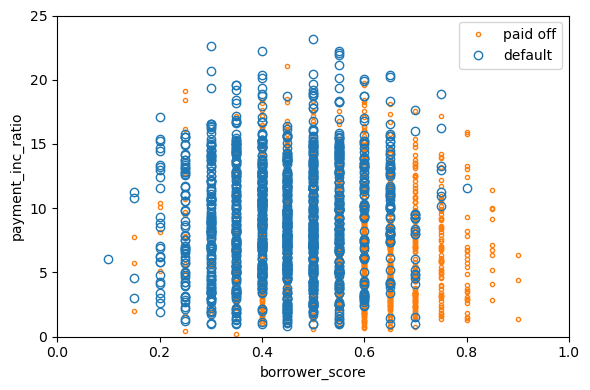

In [71]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

In [72]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1,
                            use_label_encoder=False, eval_metric='error')
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')
print(xgb_penalty.fit(train_X, train_y))

C:\Users\P6049834\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [73]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.12834587742629167
default:  0.3522
penalty:  0.3248


In [74]:

results = []
for ntree_limit in range(1, 250):
    iteration_range = [1, ntree_limit + 1]
    train_default = xgb_default.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

   iterations  default train  penalty train  default test  penalty test
0           1       0.346472       0.334758        0.3562        0.3485
1           2       0.332918       0.338379        0.3442        0.3416
2           3       0.326609       0.340473        0.3433        0.3452
3           4       0.322760       0.339766        0.3420        0.3451
4           5       0.318460       0.339653        0.3435        0.3411


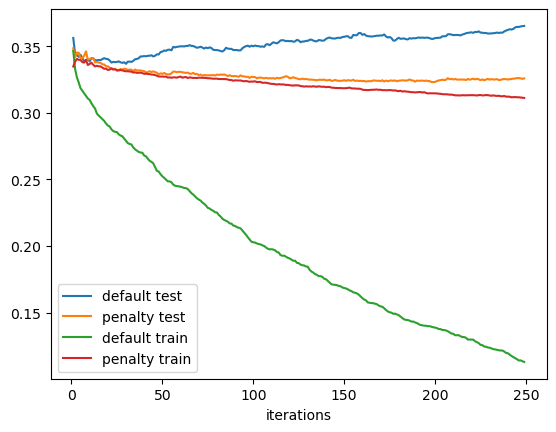

In [78]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

# Hyperparameters and Cross-Validation

In [79]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, 
                        max_depth=max_depth, learning_rate=eta,
                        eval_metric='error')
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.3293819404591008}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3330925991933097}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.3439692356889179}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3399885583841676}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.36832542656005723}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.3721347367145368}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.35365687771072}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.38861881194065395}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.3867825619067005}
   eta  max_depth  avg_error
0  0.1          3   0.329382
1  0.1          6   0.333093
2  0.1          9   0.343969
3  0.5          3   0.339989
4  0.5          6   0.368325
5  0.5          9   0.372135
6  0.9          3   0.353657
7  0.9          6   0.388619
8  0.9          9   0.386783


In [80]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        32.938194  33.309260  34.396924
0.5        33.998856  36.832543  37.213474
0.9        35.365688  38.861881  38.678256
